In [1]:
root_dir = '/Users/GitHub/Projects/AI_Project/yolov8-robot-cleaner'
dataset_dir = '/Users/GitHub/Projects/AI_Project/yolov8-robot-cleaner/data/dataset'
ultralytics_from = '/opt/homebrew/anaconda3/envs/torch_env/lib/python3.10/site-packages/ultralytics/'
ultralytics_to = '/Users/GitHub/Projects/AI_Project/yolov8-robot-cleaner/modules/ultralytics'

In [2]:
labels = ['bottlecap', 'candy', 'card', 'cellphone', 'coin', 'key', 'money', 'petbowl', 'pettoy', 'remotecontrol', 'socks', 'stone', 'tack', 'tagstring', 'wallet', 'bobbypin', 'bracelet', 'earphonewired', 'earpiece', 'gumpaper', 'hairtie', 'necklace', 'needle', 'receipt', 'ring', 'rubberband', 'usb', 'clothes', 'battery', 'mask', 'papertissue', 'stationery', 'ribbon', 'safetypin', 'shoelace', 'straw', 'toy', 'twine', 'usbcable', 'watch', 'wettissue']

In [32]:
import os, sys, shutil, yaml
from glob import glob
from IPython.display import Image, clear_output  # to display images
from zipfile import ZipFile
import cv2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt



import torch
from torch import mps
import albumentations as A
from ultralytics import YOLO
# os.symlink(ultralytics_from, ultralytics_to)

In [141]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_c, y_c, w, h = bbox
    x_min = int((x_c - w/2) * 640)
    x_max = int((x_c + w/2) * 640)
    y_min = int((y_c - h/2) * 640)
    y_max = int((y_c + h/2) * 640)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(img)

In [142]:
train_dataset = '/Users/GitHub/Projects/AI_Project/yolov8-robot-cleaner/data/dataset/train'
train_imgs = sorted((filename for filename in os.listdir(f'{train_dataset}/images') if filename.endswith('.jpg')))
train_labels = sorted((filename for filename in os.listdir(f'{train_dataset}/labels') if filename.endswith('.txt')))

imgs_len = len(train_imgs)
rand_idx = np.random.randint(low=0, high=(imgs_len-1))

imgs_len, rand_idx

(6696, 4271)

In [143]:
sample_filename = train_imgs[rand_idx][:-4]

category_id_to_name = {id:name for id, name in enumerate(labels)}
image = cv2.imread(f'{train_dataset}/images/{sample_filename}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with open(f'{train_dataset}/labels/{sample_filename}.txt', 'r') as f:
    # data = f.readlines()
    data = [[float(el) for el in line.strip().split()] for line in f.readlines() if bool(line.strip())]
    category_ids = [int(el[0]) for el in data]
    bboxes = [el[1:] for el in data]
    # bboxes = [tuple(line.strip().split()[1:]) for line in data if bool(line.strip())]
    # category_ids = [int(line.strip().split()[:][0]) for line in data if bool(line.strip())]

display(category_ids)
display(bboxes)

[39]

[[0.6703125, 0.540625, 0.5046875, 0.2078125]]

# Horizontal Flip

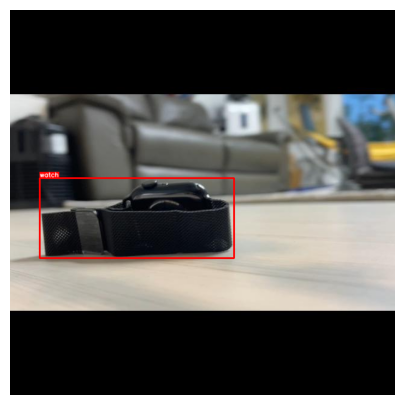

In [147]:
# Define Albumentations
T = [
    A.HorizontalFlip(p=1.0)
]


transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

# Blur Transforms

## Blur

- blur_limit : blur 강도 범위 조절. 10이 적당해보임. 그 이상은 과한 느낌

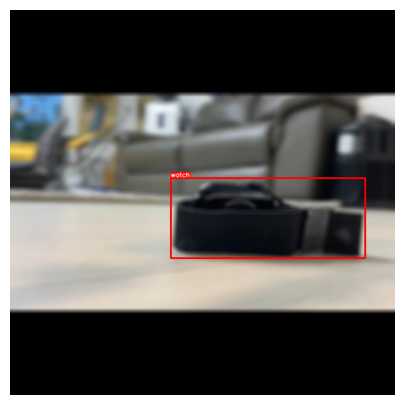

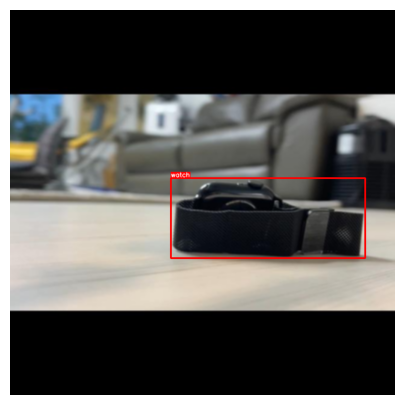

In [758]:
# Define Albumentations
T = [
    A.Blur(blur_limit=(3, 10), p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Defocus

* radius :
* alias_blur :

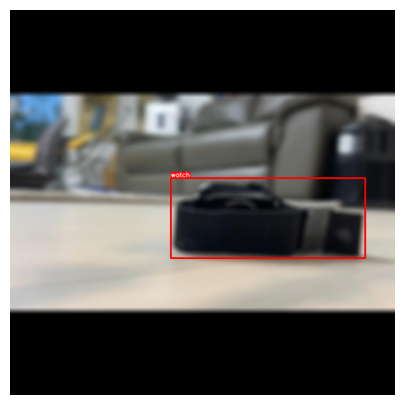

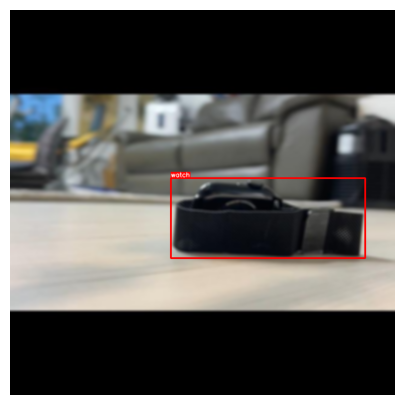

In [755]:
# Define Albumentations
T = [
    A.Defocus(radius=(3, 10), alias_blur=(0.1, 0.5), always_apply=False,
              p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## MotionBlur

이동에 따른 잔상효과 부여

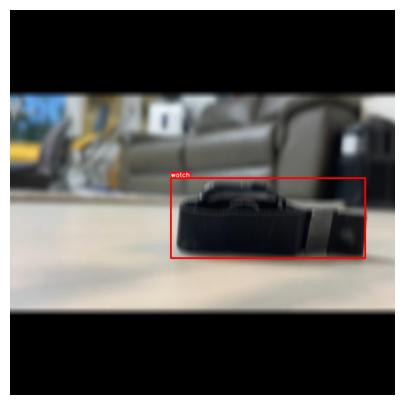

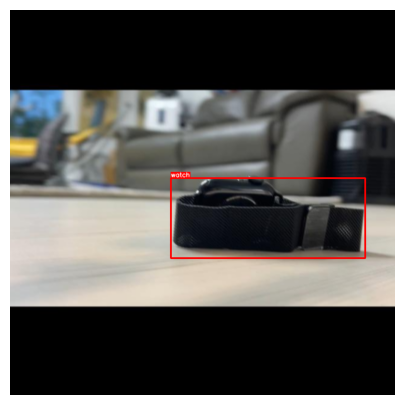

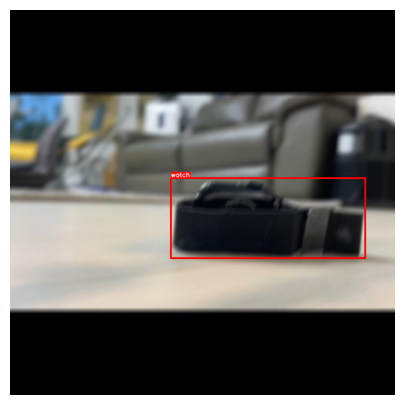

In [752]:
# Define Albumentations
T = [
    A.MotionBlur (blur_limit=21, allow_shifted=True, always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## ZoomBlur

줌 인, 줌 아웃 하면서 발생할 수 있는 흐림

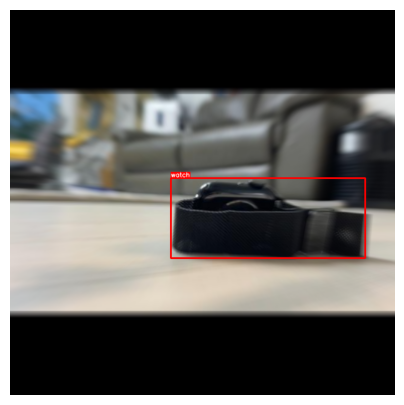

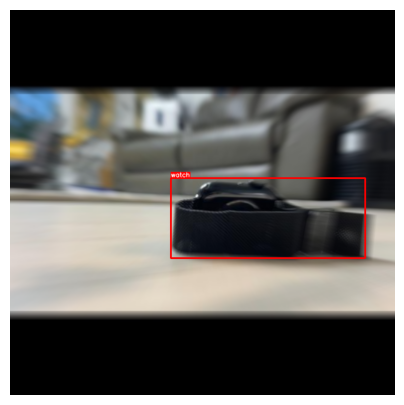

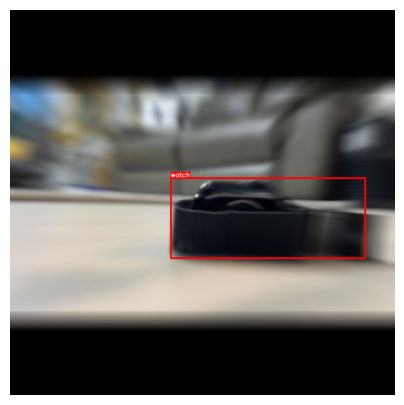

In [749]:
# Define Albumentations
T = [
    A.ZoomBlur (max_factor=1.2, step_factor=(0.01, 0.01), always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Blur 종합.

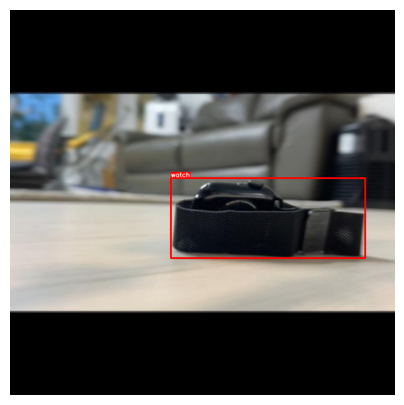

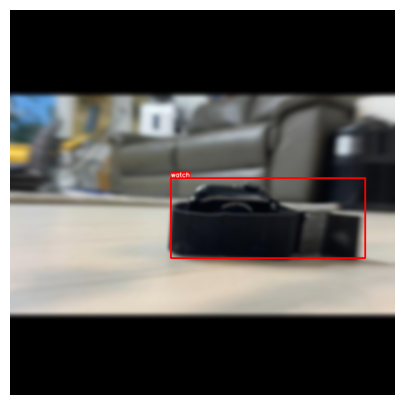

In [746]:
# Blur 종합.

# Define Albumentations
T = [
    A.Blur(blur_limit=(3, 10), p=0.5),
    A.Defocus(radius=(3, 10), alias_blur=(0.1, 0.5), always_apply=False, p=0.5),
    A.MotionBlur (blur_limit=21, allow_shifted=True, always_apply=False, p=0.5),
    A.ZoomBlur (max_factor=1.2, step_factor=(0.01, 0.01), always_apply=False, p=0.5),
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

# etc

## ChannelShuffle

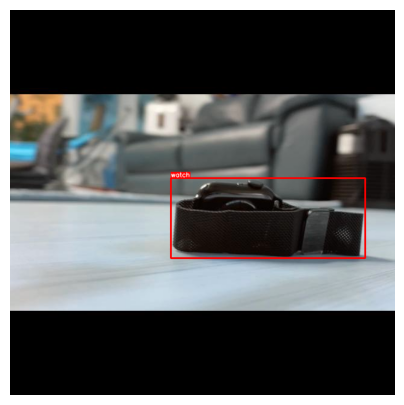

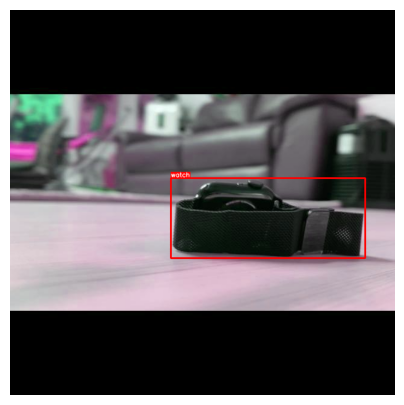

In [740]:
# Define Albumentations
T = [
    A.ChannelShuffle(p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## [CLAHE](https://m.blog.naver.com/samsjang/220543360864)

대조효과..?

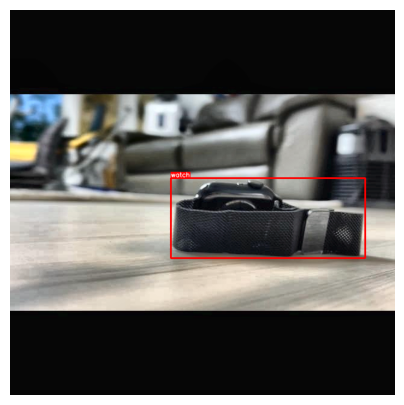

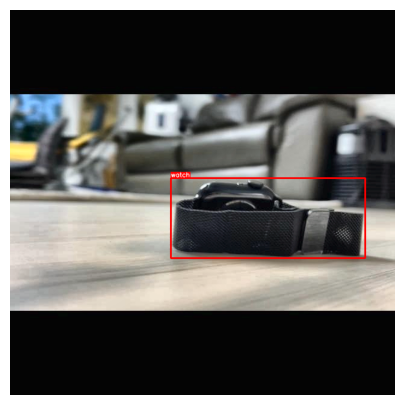

In [732]:
# Define Albumentations
T = [
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Emboss

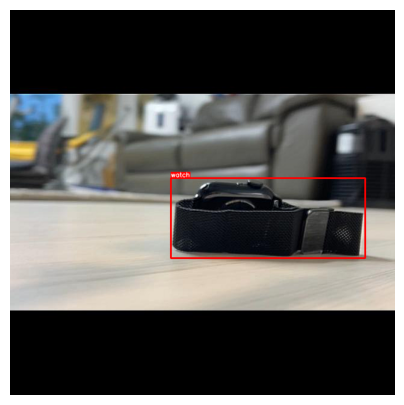

In [728]:
# Define Albumentations
T = [
    A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## [FancyPCA](https://aparico.github.io/)

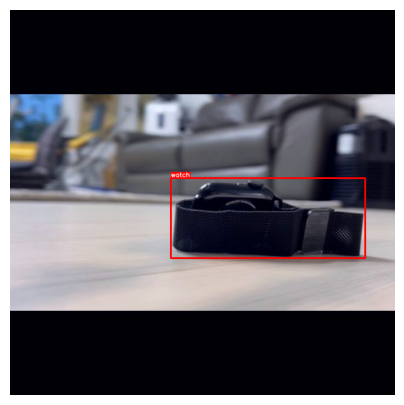

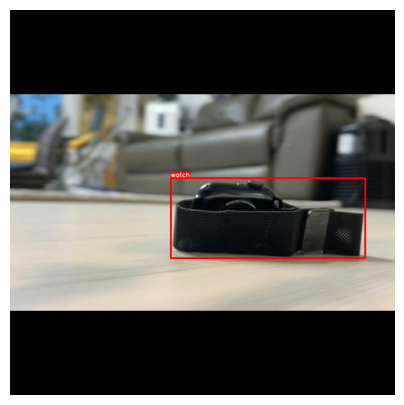

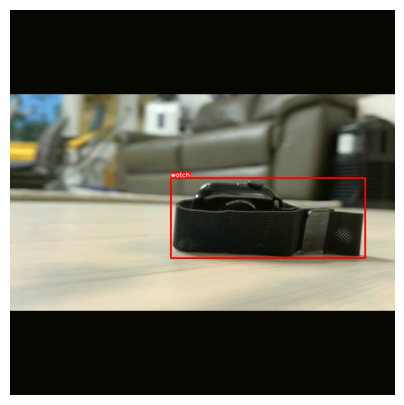

In [720]:
# Define Albumentations
T = [
    A.FancyPCA (alpha=0.1, always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## InvertImg

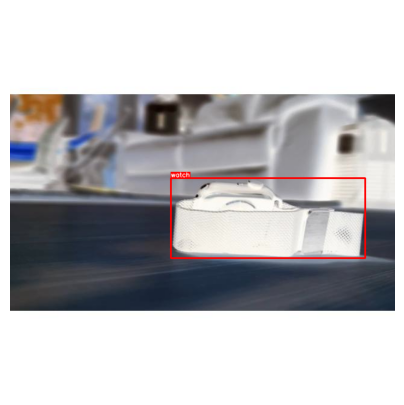

In [676]:
# Define Albumentations
T = [
    A.InvertImg(p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## ISONoise

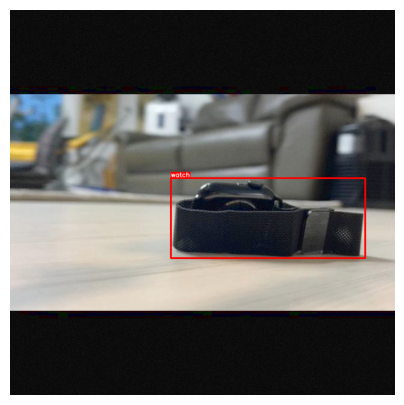

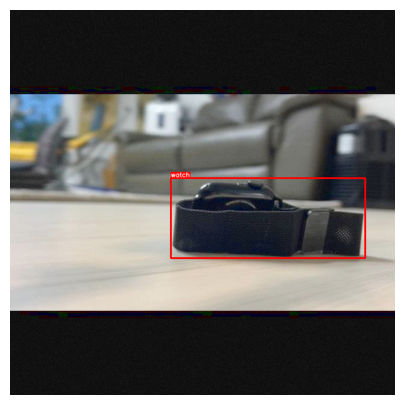

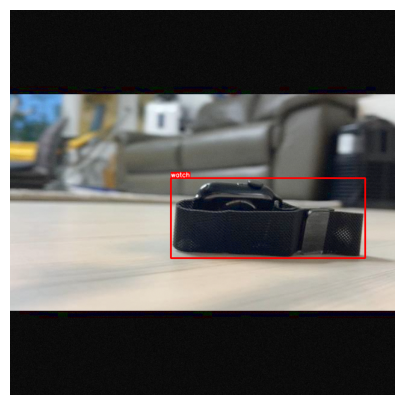

In [709]:
# Define Albumentations
T = [
    A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## MultiplicativeNoise

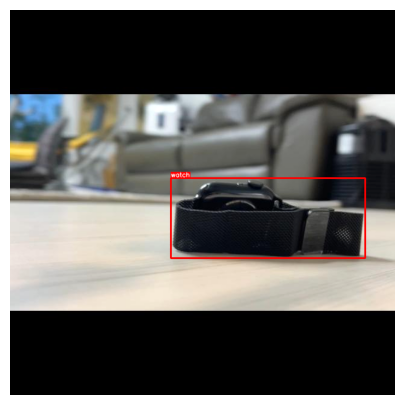

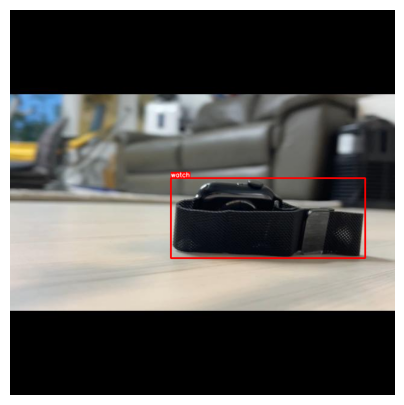

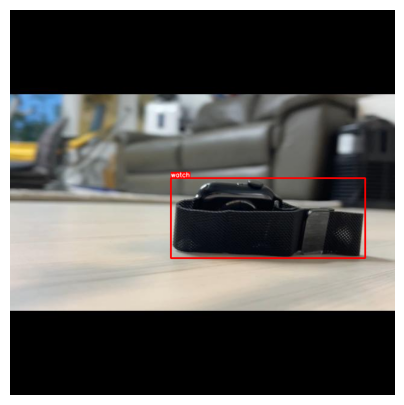

In [706]:
# Define Albumentations
T = [
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, elementwise=False, always_apply=False, p=0.5)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## RGBShift

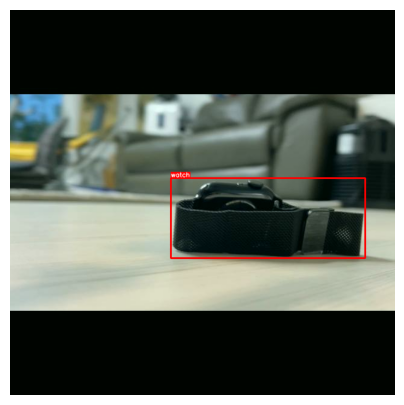

In [794]:
# Define Albumentations
T = [
    A.RGBShift (r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, always_apply=False,  p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## RingingOvershoot

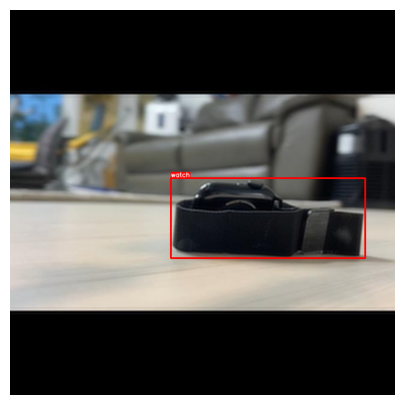

In [800]:
# Define Albumentations
T = [
    A.RingingOvershoot (blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966), always_apply=False,  p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Sharpen

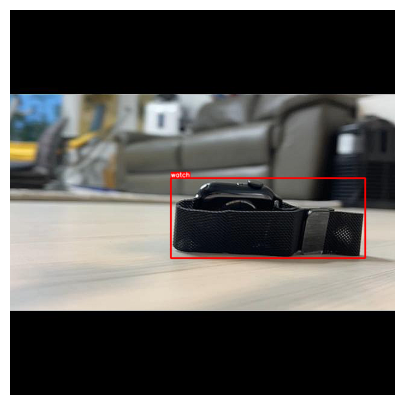

In [807]:
# Define Albumentations
T = [
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Spatter

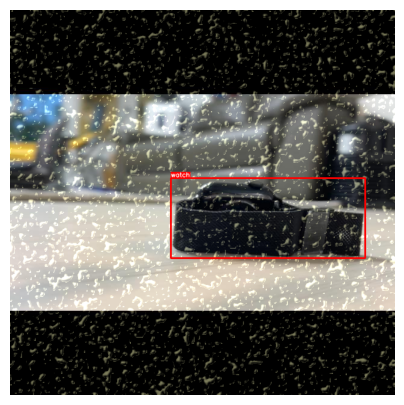

In [810]:
# Define Albumentations
T = [
    A.Spatter (mean=0.65, std=0.3, gauss_sigma=2, cutout_threshold=0.68, intensity=0.6, mode='rain', color=None, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Superpixels

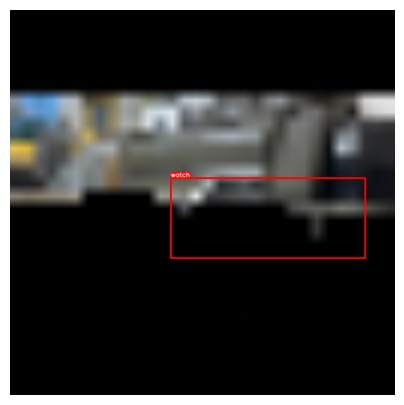

In [861]:
# Define Albumentations
T = [
    A.Superpixels (p_replace=0.1, n_segments=5, max_size=32, interpolation=1, always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## ToFloat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


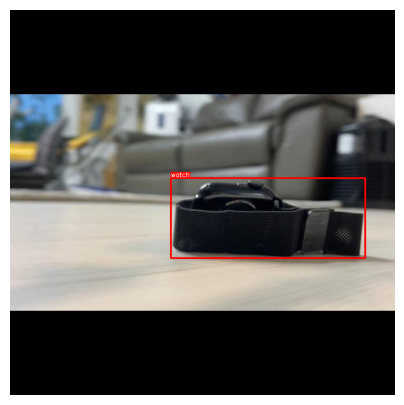

In [882]:
# Define Albumentations
T = [
    A.ToFloat (max_value=None, always_apply=False, p=1.0)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## ToGray

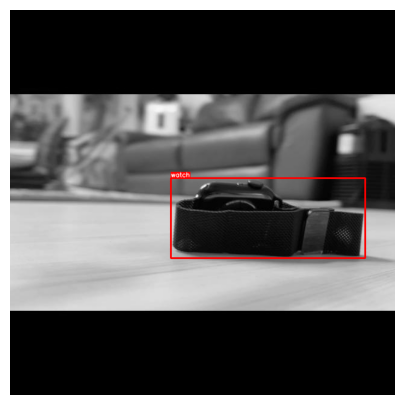

In [896]:
# Define Albumentations
T = [
    A.ToGray(p=1.0),
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

# Pixel-level Transforms

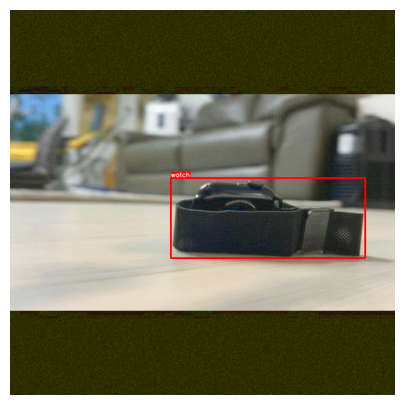

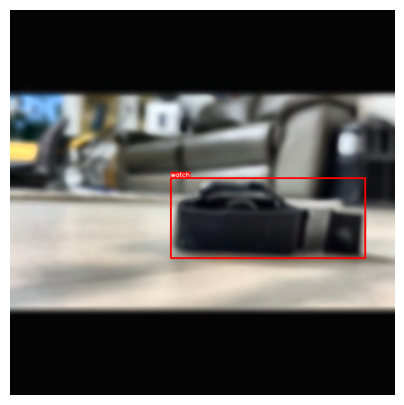

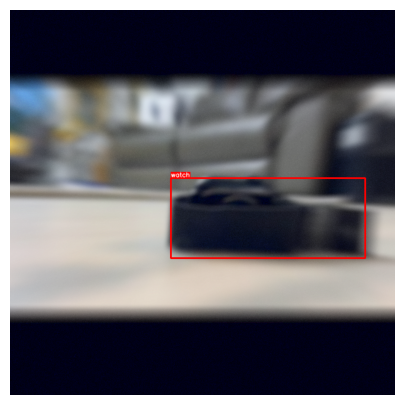

In [907]:
# 종합.

# Define Albumentations
T = [
    # Blurs
    A.Blur(blur_limit=(3, 10), p=0.5),
    A.Defocus(radius=(3, 10), alias_blur=(0.1, 0.5), always_apply=False, p=0.5),
    A.MotionBlur (blur_limit=21, allow_shifted=True, always_apply=False, p=0.5),
    A.ZoomBlur (max_factor=1.2, step_factor=(0.01, 0.01), always_apply=False, p=0.25),
    # colors
    A.OneOf([
        A.FancyPCA (alpha=0.1, always_apply=False, p=1.0),
        A.ToGray(p=1.0)],
        p=0.5),

    # etc
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5),
    A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.ImageCompression(quality_lower=75, p=0.5)
]

transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

#
# np.random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)